In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from model import ArcFaceModel
from align import FaceAligner

root = 'E:\\localDL\\vectors'

class FaceRecognizer:
    def __init__(self, model_path='E:/localDL/models/ArcFace-Res50.h5', vector_path=root):
        self.model = ArcFaceModel(size=112, training=False)
        self.model.load_weights(model_path, by_name=True, skip_mismatch=False)
        self.vector_db = self.load_vector_db(vector_path)
        self.detector = FaceAligner(size=112)

    def load_vector_db(self, root):
        """
        返回 dict{name: [N,512] ndarray}
        """
        db = {}
        for name in os.listdir(root):
            p_dir = os.path.join(root, name)
            if not os.path.isdir(p_dir): continue
            vecs = [np.load(os.path.join(p_dir, f))
                    for f in os.listdir(p_dir) if f.endswith(".npy")]
            if vecs:
                db[name] = np.stack(vecs, axis=0)  # (N,512)
        print(f"📂 已加载 {len(db)} 个身份，共 {sum(len(v) for v in db.values())} 条向量")
        return db
    
    def align_face(self,img,margin=0.2,size=112):
        """
        对人脸进行对齐
        return: 对齐后的人脸图像
        """
        if isinstance(img,str):    
            img = cv2.imread(img)

        if not isinstance(img,np.ndarray):
            raise ValueError("img应该是图像路径或ndarray类型")
        
        # 检测人脸
        face = self.detector.align(img)
        return face
    
    def align_multi_faces(self,img,margin=0.2,size=112):
        """
        多人脸识别，支持两种输入格式: 
        str格式的图像路径，np.array格式的bgr图像
        """
        if isinstance(img,str):
            img =cv2.imread(img)

        if not isinstance(img,np.ndarray):
            raise ValueError("img应该是图像路径或ndarray类型")
        
        faces = self.detector.align_multi_faces(img)
        return faces    # faces的返回值可能为none，需要在下游任务中处理none的情况
    
    def vector_extractor(self,img):
        """
        提取输入图像的 512-D 向量，使用 ArcFace 模型。
        
        Args:
            img (numpy.ndarray): 输入图像数组。

        Returns:
            numpy.ndarray: 提取的 512-D 向量。
        """
        if img.ndim == 3:
            img = np.expand_dims(img, axis=0)
        elif img.ndim != 4 or img.shape[1:] != (112, 112, 3):
            raise ValueError(f"❌ 输入图像 shape 错误，收到 {img.shape}，应为 (112,112,3) 或 (N,112,112,3)")
        vector = self.model.predict(img)
        return vector
    
    def recognize(self,img,aligned=False,thresh=0.5):
        """
        识别图像中的人脸并返回匹配的身份名称和相似度
        :param img: 输入图像路径或图像数组
        :return: (name, similarity) 或 None
        """
        face_rgb = img
        if aligned == False:    #如果传入的图像不是预先处理好的人脸
            face_rgb = self.align_face(face_rgb)
        
        if face_rgb is None:
            print("没有找到人脸")
            return None
        
        vector = self.vector_extractor(face_rgb)
        
    # 下面的计算逻辑待改写
        best_name, best_similarity = None, -1
        for name, vectors in self.vector_db.items():
            mean_similarity = cosine_sim(vector, vectors[0])
            if mean_similarity>best_similarity: # 先对平均值进行匹配，
                best_similarity = mean_similarity
                best_name = name
            
        if best_similarity>0.45:
            print(f"识别结果是{best_name},{float(best_similarity)}")
            return best_name, float(best_similarity)

        best_name, best_sim = None, -1.0
        for name, vectors in self.vector_db.items():
            for v in vectors:                          # 含均值或可跳过 [0]
                sim = cosine_sim(vector, v)
                if sim > best_sim:
                    best_name, best_sim = name, sim

        if best_sim < thresh:
            best_name = "unknown"
            best_sim = -1
            
        print(f"识别结果是{best_name},{float(best_sim)}")
        return best_name, float(best_sim)
    
    def recognize_multi(self, img):
        """
        批量识别多张图像中的人脸，返回识别结果列表
        :param imgs: 输入图像路径列表或图像数组列表
        :return: 结果列表，每个元素为 (name, similarity) 或 None
        """
        results = []
        faces = self.detector.align_multi_faces(img)
        
        for face in faces:
            try:
                # 尝试识别单张图像
                # faces是经过处理的人脸集
                result = self.recognize(face,aligned=True)
                results.append(result)
            except Exception as e:
                # 捕获并记录异常，同时添加None表示识别失败
                print(f"识别图像时出错: {str(e)}")
                results.append(None)

        print(results)
        
        return results
    
    def saveVector(self,root,name,vector):
        """
        保存单个向量
        """
        # 1 确认向量格式正确
        vec  = np.array(vector, dtype=np.float32).reshape(-1)
        if vec.ndim != 1 or vec.shape[0] != 512:
            raise ValueError(f"❌ 向量格式错误，收到 {vec.shape}，应为 (512,)")
        
        # 2 创建人物文件夹
        person_dir = os.path.join(root, name)
        if not os.path.exists(person_dir):
            os.makedirs(person_dir)

        # 3 生成唯一文件名
        file_name = f"{name}_{len(os.listdir(person_dir)) + 1}.npy" # 将编号0留出来用于放置平均向量
        file_path = os.path.join(person_dir, file_name)

        # 4 保存向量
        np.save(file_path, vec)
        print(f"✅ 向量已保存到 {file_path}")
        self.flash_db()  # 刷新数据库
        return file_path
    
    def compute_mean_vector(self,name,db):
        """
        计算指定身份的平均向量
        :param name: 身份名称
        :param db: 向量数据库
        :return: 平均向量
        """
        if name not in db or len(db[name]) == 0:
            raise ValueError(f"未找到 {name} 的向量数据")

        vecs = db[name]

        # 若担心历史向量未归一化，可在这里再保险 L2 normalize 一次
        vecs = vecs / np.linalg.norm(vecs, axis=1, keepdims=True)

        mean_vec = vecs.mean(axis=0)
        mean_vec /= np.linalg.norm(mean_vec)             # 再归一化，保持模长 = 1

        person_dir = os.path.join(root, name)
        if not os.path.exists(person_dir):
            os.makedirs(person_dir)

        # 生成唯一文件名
        file_name = f"{name}_0.npy"
        file_path = os.path.join(person_dir, file_name)

        # 保存向量
        np.save(file_path, mean_vec)
        print(f"✅ 平均向量已保存到 {file_path}")
        self.flash_db()

        return mean_vec
    
    def flash_db(self):
        """
        刷新向量数据库，重新加载所有向量
        """
        self.vector_db = self.load_vector_db(root)
        print("✅ 向量数据库已刷新")

    def register(self, img, name):
        """
        注册新身份，提取向量并保存
        :param img: 输入图像路径或图像数组
        :param name: 身份名称
        """
        face_rgb = self.align_face(img)
        if face_rgb is None:
            raise ValueError("未检测到人脸，请检查输入图像")

        vector = self.vector_extractor(face_rgb)
        self.saveVector(root, name, vector)
        self.compute_mean_vector(name, self.vector_db)
    



























def cosine_sim(a,b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    import os
    import sys
    
    sys.path.append('E:/localDL/faceai/engine')

    img_path = 'E:/localDL/wubai1.png'
    bgr = cv2.imread(img_path)
    
    # 创建对齐器
    aligner = FaceAligner(size=112)
    Recognizer = FaceRecognizer()
    
    # 获取所有人脸对齐结果
    aligned_faces = Recognizer.align_multi_faces(img_path)
    reco_results = Recognizer.recognize_multi(img_path)
    print(f"识别的结果集是：{reco_results}")




    
    if not aligned_faces:
        print("未检测到任何人脸")
        exit()
    
    # 创建图像显示布局
    n_faces = len(aligned_faces)
    fig, axs = plt.subplots(1, n_faces + 1, figsize=(4*(n_faces+1), 4))
    
    # 显示原始图像（带人脸框）
    img_with_boxes = bgr.copy()
    faces = aligner.app.get(bgr)  # 获取人脸检测结果
    
    for face in faces:
        # 绘制人脸框
        bbox = face.bbox.astype(int)
        cv2.rectangle(img_with_boxes, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        
        # 绘制关键点
        for kp in face.kps:
            cv2.circle(img_with_boxes, (int(kp[0]), int(kp[1])), 3, (0, 0, 255), -1)
        
        # 添加置信度标签
        cv2.putText(img_with_boxes, f"{face.det_score:.2f}", (bbox[0], bbox[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
    
    # 显示原始图像
    rgb_original = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
    axs[0].imshow(rgb_original)
    axs[0].set_title(f"Original ({len(faces)} faces)")
    axs[0].axis("off")
    
    # 显示所有对齐后的人脸
    for i, aligned_face in enumerate(aligned_faces):
        # 转换为RGB格式用于显示
        rgb_aligned = cv2.cvtColor((aligned_face*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
        
        # 显示对齐后的人脸
        axs[i+1].imshow(rgb_aligned)
        axs[i+1].set_title(f"Name {reco_results[i][0]}")
        axs[i+1].axis("off")
    
    plt.tight_layout()
    plt.show()

d:\anaconda\envs\tf_cpu\Lib\site-packages\albumentations\check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:999: The handshake operation timed out>
  data = fetch_version_info()


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'device_id': '0', 'has_user_compute_stream': '0', 'cudnn_conv1d_pad_to_nc1d': '0', 'user_compute_stream': '0', 'gpu_external_alloc': '0', 'gpu_mem_limit': '18446744073709551615', 'enable_cuda_graph': '0', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'do_copy_in_default_stream': '1', 'cudnn_conv_use_max_workspace': '1', 'tunable_op_enable': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'prefer_nhwc': '0', 'use_ep_level_unified_stream': '0', 'use_tf32': '1', 'sdpa_kernel': '0', 'fuse_conv_bias': '0'}, 'CPUExecutionProvider': {}}
find model: C:\Users\susan/.insightface\models\buffalo_1\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'

AttributeError: 'str' object has no attribute 'shape'

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'device_id': '0', 'has_user_compute_stream': '0', 'cudnn_conv1d_pad_to_nc1d': '0', 'user_compute_stream': '0', 'gpu_external_alloc': '0', 'gpu_mem_limit': '18446744073709551615', 'enable_cuda_graph': '0', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'do_copy_in_default_stream': '1', 'cudnn_conv_use_max_workspace': '1', 'tunable_op_enable': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'prefer_nhwc': '0', 'use_ep_level_unified_stream': '0', 'use_tf32': '1', 'sdpa_kernel': '0', 'fuse_conv_bias': '0'}, 'CPUExecutionProvider': {}}
find model: C:\Users\susan/.insightface\models\buffalo_1\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'

<ipython-input-2-86ad559ae0fb>:112: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"识别结果是{best_name},{float(best_sim)}")
<ipython-input-2-86ad559ae0fb>:113: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return best_name, float(best_sim)


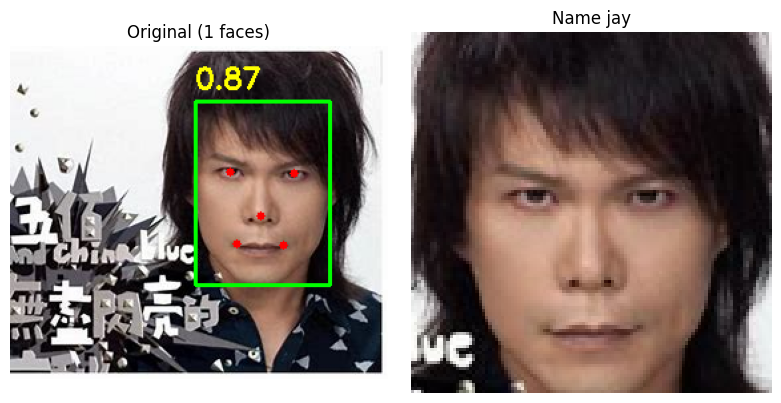

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from model import ArcFaceModel
from align import FaceAligner

root = 'E:\\localDL\\vectors'

class FaceRecognizer:
    def __init__(self, model_path='E:/localDL/models/ArcFace-Res50.h5', vector_path=root):
        self.model = ArcFaceModel(size=112, training=False)
        self.model.load_weights(model_path, by_name=True, skip_mismatch=False)
        self.vector_db = self.load_vector_db(vector_path)
        self.detector = FaceAligner(size=112)

    def load_vector_db(self, root):
        """
        返回 dict{name: [N,512] ndarray}
        """
        db = {}
        for name in os.listdir(root):
            p_dir = os.path.join(root, name)
            if not os.path.isdir(p_dir): continue
            vecs = [np.load(os.path.join(p_dir, f))
                    for f in os.listdir(p_dir) if f.endswith(".npy")]
            if vecs:
                db[name] = np.stack(vecs, axis=0)  # (N,512)
        print(f"📂 已加载 {len(db)} 个身份，共 {sum(len(v) for v in db.values())} 条向量")
        return db
    
    def align_face(self,img,margin=0.2,size=112):
        """
        对人脸进行对齐
        return: 对齐后的人脸图像
        """
        if isinstance(img,str):    
            img = cv2.imread(img)

        if not isinstance(img,np.ndarray):
            raise ValueError("img应该是图像路径或ndarray类型")
        
        # 检测人脸
        face = self.detector.align(img)
        return face
    
    def align_multi_faces(self,img,margin=0.2,size=112):
        """
        多人脸识别，支持两种输入格式: 
        str格式的图像路径，np.array格式的bgr图像
        """
        if isinstance(img,str):
            img =cv2.imread(img)

        if not isinstance(img,np.ndarray):
            raise ValueError("img应该是图像路径或ndarray类型")
        
        faces = self.detector.align_multi_faces(img)
        return faces    # faces的返回值可能为none，需要在下游任务中处理none的情况
    
    def vector_extractor(self,img):
        """
        提取输入图像的 512-D 向量，使用 ArcFace 模型。
        
        Args:
            img (numpy.ndarray): 输入图像数组。

        Returns:
            numpy.ndarray: 提取的 512-D 向量。
        """
        if img.ndim == 3:
            img = np.expand_dims(img, axis=0)
        elif img.ndim != 4 or img.shape[1:] != (112, 112, 3):
            raise ValueError(f"❌ 输入图像 shape 错误，收到 {img.shape}，应为 (112,112,3) 或 (N,112,112,3)")
        vector = self.model.predict(img)
        return vector
    
    def recognize(self,img,aligned=False):
        """
        识别图像中的人脸并返回匹配的身份名称和相似度
        :param img: 输入图像路径或图像数组
        :return: (name, similarity) 或 None
        """
        face_rgb = img
        if aligned == False:    #如果传入的图像不是预先处理好的人脸
            face_rgb = self.align_face(face_rgb)
        
        if face_rgb is None:
            print("没有找到人脸")
            return None
        
        vector = self.vector_extractor(face_rgb)
        
    # 下面的计算逻辑待改写
        best_name, best_similarity = None, -1
        for name, vectors in self.vector_db.items():
            mean_similarity = cosine_sim(vector, vectors[0])
            if mean_similarity>best_similarity: # 先对平均值进行匹配，
                best_similarity = mean_similarity
                best_name = name
            
        if best_similarity>0.45:
            print(f"识别结果是{best_name},{float(best_similarity)}")
            return best_name, float(best_similarity)

        best_name, best_sim = None, -1.0
        for name, vectors in self.vector_db.items():
            for v in vectors:                          # 含均值或可跳过 [0]
                sim = cosine_sim(vector, v)
                if sim > best_sim:
                    best_name, best_sim = name, sim
        print(f"识别结果是{best_name},{float(best_sim)}")
        return best_name, float(best_sim)
    
    def recognize_multi(self, img):
        """
        批量识别多张图像中的人脸，返回识别结果列表
        :param imgs: 输入图像路径列表或图像数组列表
        :return: 结果列表，每个元素为 (name, similarity) 或 None
        """
        results = []
        faces = self.align_multi_faces(img)
        
        for face in faces:
            try:
                # 尝试识别单张图像
                # faces是经过处理的人脸集
                result = self.recognize(face,aligned=True)
                results.append(result)
            except Exception as e:
                # 捕获并记录异常，同时添加None表示识别失败
                print(f"识别图像时出错: {str(e)}")
                results.append(None)

        print(results)
        
        return results
    
    def saveVector(self,root,name,vector):
        """
        保存单个向量
        """
        # 1 确认向量格式正确
        vec  = np.array(vector, dtype=np.float32).reshape(-1)
        if vec.ndim != 1 or vec.shape[0] != 512:
            raise ValueError(f"❌ 向量格式错误，收到 {vec.shape}，应为 (512,)")
        
        # 2 创建人物文件夹
        person_dir = os.path.join(root, name)
        if not os.path.exists(person_dir):
            os.makedirs(person_dir)

        # 3 生成唯一文件名
        file_name = f"{name}_{len(os.listdir(person_dir)) + 1}.npy" # 将编号0留出来用于放置平均向量
        file_path = os.path.join(person_dir, file_name)

        # 4 保存向量
        np.save(file_path, vec)
        print(f"✅ 向量已保存到 {file_path}")
        self.flash_db()  # 刷新数据库
        return file_path
    
    def compute_mean_vector(self,name,db):
        """
        计算指定身份的平均向量
        :param name: 身份名称
        :param db: 向量数据库
        :return: 平均向量
        """
        if name not in db or len(db[name]) == 0:
            raise ValueError(f"未找到 {name} 的向量数据")

        vecs = db[name]

        # 若担心历史向量未归一化，可在这里再保险 L2 normalize 一次
        vecs = vecs / np.linalg.norm(vecs, axis=1, keepdims=True)

        mean_vec = vecs.mean(axis=0)
        mean_vec /= np.linalg.norm(mean_vec)             # 再归一化，保持模长 = 1

        person_dir = os.path.join(root, name)
        if not os.path.exists(person_dir):
            os.makedirs(person_dir)

        # 生成唯一文件名
        file_name = f"{name}_0.npy"
        file_path = os.path.join(person_dir, file_name)

        # 保存向量
        np.save(file_path, mean_vec)
        print(f"✅ 平均向量已保存到 {file_path}")
        self.flash_db()

        return mean_vec
    
    def flash_db(self):
        """
        刷新向量数据库，重新加载所有向量
        """
        self.vector_db = self.load_vector_db(root)
        print("✅ 向量数据库已刷新")

    def register(self, img, name):
        """
        注册新身份，提取向量并保存
        :param img: 输入图像路径或图像数组
        :param name: 身份名称
        """
        face_rgb = self.align_face(img)
        if face_rgb is None:
            raise ValueError("未检测到人脸，请检查输入图像")

        vector = self.vector_extractor(face_rgb)
        self.saveVector(root, name, vector)
        self.compute_mean_vector(name, self.vector_db)
    



























def cosine_sim(a,b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    import os
    import sys
    
    sys.path.append('E:/localDL/faceai/engine')

    img_path = 'E:/localDL/wubai1.png'
    bgr = cv2.imread(img_path)
    
    # 创建对齐器
    aligner = FaceAligner(size=112)
    Recognizer = FaceRecognizer()
    
    # 获取所有人脸对齐结果
    aligned_faces = Recognizer.align_multi_faces(img_path)
    reco_results = Recognizer.recognize_multi(img_path)
    print(f"识别的结果集是：{reco_results}")




    
    if not aligned_faces:
        print("未检测到任何人脸")
        exit()
    
    # 创建图像显示布局
    n_faces = len(aligned_faces)
    fig, axs = plt.subplots(1, n_faces + 1, figsize=(4*(n_faces+1), 4))
    
    # 显示原始图像（带人脸框）
    img_with_boxes = bgr.copy()
    faces = aligner.app.get(bgr)  # 获取人脸检测结果
    
    for face in faces:
        # 绘制人脸框
        bbox = face.bbox.astype(int)
        cv2.rectangle(img_with_boxes, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        
        # 绘制关键点
        for kp in face.kps:
            cv2.circle(img_with_boxes, (int(kp[0]), int(kp[1])), 3, (0, 0, 255), -1)
        
        # 添加置信度标签
        cv2.putText(img_with_boxes, f"{face.det_score:.2f}", (bbox[0], bbox[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
    
    # 显示原始图像
    rgb_original = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
    axs[0].imshow(rgb_original)
    axs[0].set_title(f"Original ({len(faces)} faces)")
    axs[0].axis("off")
    
    # 显示所有对齐后的人脸
    for i, aligned_face in enumerate(aligned_faces):
        # 转换为RGB格式用于显示
        rgb_aligned = cv2.cvtColor((aligned_face*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
        
        # 显示对齐后的人脸
        axs[i+1].imshow(rgb_aligned)
        axs[i+1].set_title(f"Name {reco_results[i][0]}")
        axs[i+1].axis("off")
    
    plt.tight_layout()
    plt.show()